## Embedding Space Exploration

In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from small_concept_model.inverter import get_encoder
from small_concept_model.data import clean_text, SCMDataset
from small_concept_model.model import SmallConceptModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = load_dataset("francescoortame/bookcorpus-sorted-100k16x", split="train")
flat_texts = [t for sublist in data["slice"] for t in sublist]
flat_texts = [clean_text(t) for t in flat_texts]

In [4]:
encoder = get_encoder("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = encoder.encode(
    flat_texts, batch_size=32, convert_to_tensor=True, show_progress_bar=True
)

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [10:03<00:00, 82.79it/s]


In [5]:
stds = embeddings.std(dim=0, unbiased=True)
means = embeddings.mean(dim=0)

sorted_dims = torch.argsort(stds, descending=True)

print("Top 10 dims by standard deviation:")
for rank, dim_idx in enumerate(sorted_dims[:10]):
    print(
        f"  rank {rank+1:>2}: dim {dim_idx.item():>3} (std = {stds[dim_idx].item():.4f})"
    )

Top 10 dims by standard deviation:
  rank  1: dim  99 (std = 0.4659)
  rank  2: dim 316 (std = 0.2982)
  rank  3: dim 250 (std = 0.2815)
  rank  4: dim 119 (std = 0.2797)
  rank  5: dim 261 (std = 0.2796)
  rank  6: dim 125 (std = 0.2784)
  rank  7: dim  20 (std = 0.2776)
  rank  8: dim  68 (std = 0.2741)
  rank  9: dim  92 (std = 0.2715)
  rank 10: dim 176 (std = 0.2705)


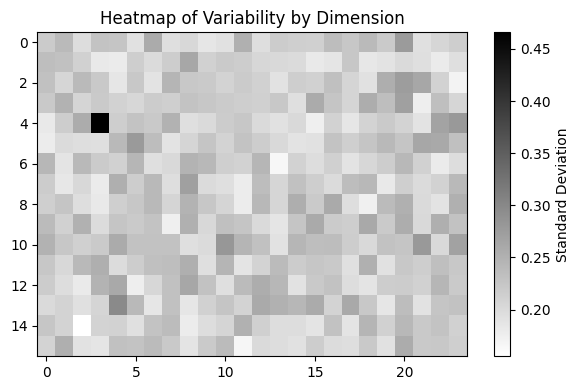

In [6]:
import matplotlib.pyplot as plt

x_2d = stds.view(16, 24)

arr = x_2d.cpu().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(arr, cmap="gray_r", aspect="auto", interpolation="nearest")
plt.colorbar(label="Standard Deviation")
plt.title("Heatmap of Variability by Dimension")
plt.tight_layout()
plt.show()

In [7]:
reshaped_embeddings = embeddings.contiguous().view(100000, 16, 384)
dataset = SCMDataset(reshaped_embeddings)

## SCM Definition

In [8]:
# print(input_batch.shape)
print(means.shape)
print(stds.shape)

torch.Size([384])
torch.Size([384])


#### Loss Functions

In [10]:
import torch.nn as nn
import torch.nn.functional as F

stds = embeddings.std(dim=0, unbiased=False)
sigma_min = stds.min().item()
sigma_max = stds.max().item()

if sigma_max - sigma_min < 1e-12:
    weights = torch.ones_like(stds) * 1e-3
else:
    weights = (stds - sigma_min) / (sigma_max - sigma_min)
    epsilon = 1e-6
    weights = torch.clamp(weights, min=epsilon)


class WeightedMSELoss(nn.Module):
    def __init__(self, weight_vector: torch.Tensor):
        super().__init__()
        self.register_buffer("w", weight_vector.view(1, -1))

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if predictions.shape != targets.shape:
            raise ValueError(
                f"predictions and targets must have same shape. "
                f"Got {predictions.shape} vs {targets.shape}."
            )
        se = (predictions - targets) ** 2
        weighted_se = se * self.w
        return weighted_se.mean()


class MSELossWithAvgPenalty(nn.Module):
    def __init__(self, avg_vector: torch.Tensor):
        super().__init__()
        self.register_buffer("avg", avg_vector)

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if predictions.shape != targets.shape:
            raise ValueError(
                f"predictions and targets must have same shape. "
                f"Got {predictions.shape} vs {targets.shape}."
            )

        B, T, D = predictions.shape

        pred_flat = predictions.reshape(-1, D)  # [B*T, 384]
        pred_flat_norm = F.normalize(pred_flat, p=2, dim=1)  # [B*T, 384]
        avg_expanded = self.avg.unsqueeze(0).expand(pred_flat_norm.size(0), -1)
        cos_sims = (pred_flat_norm * avg_expanded).sum(dim=1)  # [B*T]
        batch_avg_cos_sim = cos_sims.mean().item()

        se = (predictions - targets) ** 2

        loss = se.mean() + batch_avg_cos_sim

        return loss


class AntiAverageLoss(torch.nn.Module):
    """
    Loss function that INCREASES when predictions get closer to the average embedding.
    This will force the model to predict anything BUT the average.
    If your model still collapses with this loss, there's definitely a bug.
    """

    def __init__(self, avg_embedding, penalty_weight=1.0):
        super().__init__()
        self.register_buffer("avg_embedding", avg_embedding)
        self.penalty_weight = penalty_weight

    def forward(self, predictions, targets):
        # predictions: [B, T, D] or [B*T, D]
        # targets: [B, T, D] or [B*T, D]

        # Flatten if needed
        if predictions.dim() == 3:
            pred_flat = predictions.reshape(-1, predictions.size(-1))
            tgt_flat = targets.reshape(-1, targets.size(-1))
        else:
            pred_flat = predictions
            tgt_flat = targets

        # Normalize vectors
        pred_norm = F.normalize(pred_flat, p=2, dim=1)
        avg_norm = F.normalize(self.avg_embedding, p=2, dim=0)

        # Cosine similarity with average (higher = more similar to average)
        cos_sim_with_avg = torch.mm(pred_norm, avg_norm.unsqueeze(1)).squeeze()

        # Convert to penalty: higher similarity = higher loss
        # Use sigmoid to bound the penalty and make it smooth
        avg_penalty = torch.sigmoid(
            cos_sim_with_avg * 5
        )  # Scale factor makes it more sensitive

        # Main loss: encourage predictions to match targets
        main_loss = 1 - F.cosine_similarity(pred_flat, tgt_flat, dim=1)

        # Combined loss: minimize target error + maximize distance from average
        total_loss = main_loss.mean() + self.penalty_weight * avg_penalty.mean()

        return total_loss, main_loss.mean()


class CosineSimilarityLoss(nn.Module):
    def __init__(self, eps: float = 1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if predictions.shape != targets.shape:
            raise ValueError(
                f"predictions and targets must have same shape. "
                f"Got {predictions.shape} vs {targets.shape}."
            )

        cos_sim = F.cosine_similarity(predictions, targets, dim=-1, eps=self.eps)
        loss = 1.0 - cos_sim
        return loss.mean()


def combined_loss(pred, target, alpha=0.7):
    mse = F.mse_loss(pred, target)
    cosine = 1 - F.cosine_similarity(pred, target, dim=-1).mean()
    return alpha * mse + (1 - alpha) * cosine

I suspect the model is always predicting the mean vector, let's check if that's the case.

In [11]:
avg_embedding = embeddings.mean(dim=0)
avg_embedding = avg_embedding / avg_embedding.norm(p=2, dim=0)
avg_embedding = avg_embedding.to(device)

In [14]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)

model = SmallConceptModel(
    d_model=256,
    d_embed=384,
    nhead=4,
    num_layers=3,
    dim_feedforward=256 * 4,
    dropout=0.0,
    max_seq_len=dataset.seq_len,  # so positional encoding covers full length
    means=means,
    stds=stds
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#loss_fn = WeightedMSELoss(weights.to(device))
#loss_fn = nn.MSELoss()
#loss_fn = CosineSimilarityLoss()
#loss_fn = MSELossWithAvgPenalty(avg_embedding)
loss_fn = AntiAverageLoss(avg_embedding, 0.4)

In [15]:
num_epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.train()
for epoch in range(num_epochs):
    for idx, (input_batch, target_batch) in enumerate(dataloader):
        model.train()
        # input_batch, target_batch: [B, T, D]
        input_batch = input_batch.to(device)  # [B, T, 384]
        target_batch = target_batch.to(device)  # [B, T, 384]

        noise_scale = 0.01

        noise = torch.randn_like(input_batch) * noise_scale
        input_batch = input_batch + noise

        optimizer.zero_grad()
        preds = model(input_batch)  # preds.shape = [B, T, 384]
        
        #loss = combined_loss(preds, target_batch, 0.0)
        loss, main_loss = loss_fn(
           preds, target_batch
        )  # compare preds[:, t, :] to target[:, t, :]
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            B, T, D = preds.shape

            pred_flat = preds.reshape(-1, D)  # [B*T, 384]
            pred_flat_norm = F.normalize(pred_flat, p=2, dim=1)  # [B*T, 384]
            avg_expanded = avg_embedding.unsqueeze(0).expand(pred_flat_norm.size(0), -1)
            cos_sims = (pred_flat_norm * avg_expanded).sum(dim=1)  # [B*T]
            batch_avg_cos_sim = cos_sims.mean().item()

            tgt_flat = target_batch.reshape(-1, D)  # [B*T, 384]
            tgt_flat_norm = F.normalize(tgt_flat, p=2, dim=1)
            cos_sims = (tgt_flat_norm * avg_expanded).sum(dim=1)  # [B*T]
            tgt_batch_avg_cos_sim = cos_sims.mean().item()

        if (idx + 1) % 20 == 0:
            print(
                f"(Epoch {epoch+1}) {idx+1} | Loss = {loss.item():.6f} | Main Loss = {main_loss.item():.6f}| Pred Sim = {batch_avg_cos_sim:.6f} | True Sim = {tgt_batch_avg_cos_sim:.6f}"
                #f"(Epoch {epoch+1}) {idx+1} | Loss = {loss.item():.6f} | Pred Sim = {batch_avg_cos_sim:.6f} | True Sim = {tgt_batch_avg_cos_sim:.6f}"
            )
    print(f"*** Epoch {epoch+1}/{num_epochs} — Loss = {loss.item():.6f} ***")

(Epoch 1) 20 | Loss = 1.001412 | Main Loss = 0.604741| Pred Sim = 0.957906 | True Sim = 0.378504
(Epoch 1) 40 | Loss = 0.976011 | Main Loss = 0.595705| Pred Sim = 0.846468 | True Sim = 0.386116
(Epoch 1) 60 | Loss = 0.965262 | Main Loss = 0.587218| Pred Sim = 0.830216 | True Sim = 0.387383
(Epoch 1) 80 | Loss = 0.963661 | Main Loss = 0.593783| Pred Sim = 0.794992 | True Sim = 0.389466
(Epoch 1) 100 | Loss = 0.959772 | Main Loss = 0.606118| Pred Sim = 0.724351 | True Sim = 0.379781
(Epoch 1) 120 | Loss = 0.955879 | Main Loss = 0.590954| Pred Sim = 0.799094 | True Sim = 0.394957
(Epoch 1) 140 | Loss = 0.956886 | Main Loss = 0.589191| Pred Sim = 0.782839 | True Sim = 0.388227
(Epoch 1) 160 | Loss = 0.964622 | Main Loss = 0.624056| Pred Sim = 0.697469 | True Sim = 0.386896
(Epoch 1) 180 | Loss = 0.966187 | Main Loss = 0.646699| Pred Sim = 0.606930 | True Sim = 0.380787
(Epoch 1) 200 | Loss = 0.956419 | Main Loss = 0.608168| Pred Sim = 0.722470 | True Sim = 0.379809
(Epoch 1) 220 | Loss = 0

In [16]:
torch.save(model.state_dict(), "saved_models/scm/scm_test.pth")

---